# Run "Classic" pandas version of processing with SVI Bayesian method

In [53]:
import pandas as pd
#import MarineDNA as md
import plotly.express as px
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import itertools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import the data

In [54]:
file1 = "../Data/merged_data/no_duplicates/Merged2018_16S_otu_filtered.csv"
file2 = "../Data/merged_data/no_duplicates/Merged2018_18S_otu_filtered.csv"
asvs_16S = pd.read_csv(file1, index_col=0)
asvs_18S = pd.read_csv(file2, index_col=0)


In [55]:
# get lists of sample and asv names
labels_samples_16S = list(asvs_16S)
labels_samples_18S = list(asvs_18S)
labels_asvs_16S = asvs_16S.index.tolist()
labels_asvs_18S = asvs_18S.index.tolist()

print('Number of 16S ASVs:', len(labels_asvs_16S))
print('Number of 16S samples:', len(labels_samples_16S))
print('Number of 18S ASVs:', len(labels_asvs_18S))
print('Number of 18S samples:', len(labels_samples_18S))

Number of 16S ASVs: 7077
Number of 16S samples: 131
Number of 18S ASVs: 10475
Number of 18S samples: 131


## Functions

In [4]:
# Return data frame of a draw of relative percent of occurrence from a beta distribution
# fit to observed occurrence counts
#   df: data frame where rows = ASVs and columns = samples
def ranRelPct(df, asLogOdds = True):
    import pandas as pd
    import numpy as np
    
    def betaCol(col):
        beta_dist = np.random.beta(col + 1, col.sum() - col + 1)
        return beta_dist / beta_dist.sum()
    result = np.empty([df.shape[0], df.shape[1]])
    for i in range(result.shape[1]):
        result[:,i] = betaCol(df.iloc[:,i])
    if asLogOdds:
        result = np.log(result / (1 - result))
    return pd.DataFrame(result, index = df.index, columns = df.columns).transpose()

In [5]:
# Does hierarchical clustering on data frame where rows are samples and columns are ASVs
# Returns array of cluster labels for rows
def doClustering(df, num_clusts, num_pcs = None):
    from sklearn.cluster import AgglomerativeClustering
    
    agg_clust = AgglomerativeClustering(n_clusters = num_clusts, metric = "euclidean", linkage = "ward")
    labels = agg_clust.fit_predict(df)
    return labels.astype(str)

In [6]:
def pctSame(df, n_clust, n_rep):
    if n_clust >= df.shape[0]:
        return 100
    
    def isSameCluster(pws, df, col):
        return df.iloc[pws[0], col] == df.iloc[pws[1], col]
    
    def maxSame(row):
        unique, counts = np.unique(row, return_counts=True)
        return max(counts)
    
    # cluster a random sample of logit(relative percentages)
    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]
    cluster_samples = pd.DataFrame(cluster_samples).transpose()
    # unique pairs of rows
    *pws_rows, = itertools.combinations(range(cluster_samples.shape[0]), 2)
    pws_same = np.empty([len(pws_rows), n_rep])
    for c in range(pws_same.shape[1]):
        for r in range(pws_same.shape[0]):
            pws_same[r, c] = cluster_samples.iloc[pws_rows[r][0], c] == cluster_samples.iloc[pws_rows[r][1], c]
    
    # get the maximum number replicates that have the same value (True or False) for each sample
    num_same = [maxSame(pws_same[row, :]) for row in range(pws_same.shape[0])]
    # convert to percentage with maximum of same value across all replicates
    return np.sum(num_same) * 100 / (pws_same.shape[0] * pws_same.shape[1])

In [7]:
# Does PCA
#   df: data frame where rows = samples and columns = ASVs
#   num_pcs: number of components to return. if None, return maximum number
# Returns a dictionary containing :
#   scores: array of PCA scores
#   loadings: array of PCA loadings
def doPCA(df, num_pcs = None):
    import numpy as np
    from sklearn.decomposition import PCA
    
    max_pcs = min(df.shape[0] - 1, df.shape[1] - 1)
    if num_pcs is None:
        num_pcs = max_pcs
    elif num_pcs > max_pcs:
        num_pcs = max_pcs
    pca = PCA(n_components = num_pcs)
    pca_fit = pca.fit(df)
    pca_results = {
        "scores": pca_fit.transform(df),
        "loadings": np.transpose(pca_fit.components_),
        "explained_variance": pca.explained_variance_ratio_
        # add line exported explained variance
    }
    return pca_results

## One draw

In [8]:
# one random draw
ran_lo_16S = ranRelPct(asvs_16S)
ran_lo_18S = ranRelPct(asvs_18S)
# one PCA
pca_results_16S = doPCA(ran_lo_16S,num_pcs =6)
pca_results_18S = doPCA(ran_lo_18S,num_pcs =6)

In [9]:
# Format PCA results:
#16S
df = pd.DataFrame(pca_results_16S["scores"], index=labels_samples_16S)
df.columns = '16S_PC'+(df.columns + 1).astype(str)
pca_scores_16S = df.copy()

#18S
df = pd.DataFrame(pca_results_18S["scores"], index=labels_samples_18S)
df.columns = '18S_PC'+(df.columns + 1).astype(str)
pca_scores_18S = df.copy()
df.head()

,18S_PC1,18S_PC2,18S_PC3,18S_PC4,18S_PC5,18S_PC6
CN18FESPkoa_SC24,27.168385,55.672389,-23.867697,1.061495,-4.938960,-9.462011
CN18Fc21_6_eDNA,-32.399833,55.545274,-25.455611,4.140598,-2.818571,7.004974
CN18Fc22_6_eDNA,-28.113601,57.174851,-23.526761,6.749939,3.728687,9.672329
CN18Fc24_6_eDNA,-6.576927,56.577954,-26.070029,1.258048,-0.281699,4.559508
CN18Fc25_5_eDNA,-21.993674,31.913772,-10.837168,-3.257475,-7.573353,9.147380


In [16]:
# Make dataframe of first 6 16S PC scores and first 2 18S PC scores
df = pd.concat([pca_scores_16S.iloc[:,:7], pca_scores_18S.iloc[:,:2]], axis=1)
comb_scores = df.copy()
comb_scores.head()

,16S_PC1,16S_PC2,16S_PC3,16S_PC4,16S_PC5,16S_PC6,18S_PC1,18S_PC2
CN18Fc43_5_eDNA,-57.979814,4.694228,15.656741,-4.089590,0.158013,-5.874627,-45.980560,51.302749
CN18FESPkoa_SC58,-56.143555,7.528719,11.314178,-5.004067,-0.389400,-0.290039,-45.561586,52.832804
CN18FESPkoa_SC43,-59.480435,1.803356,9.862384,-4.636202,0.136230,-6.480024,-20.298630,63.203718
CN18FESPkoa_SC40,-65.979320,0.487794,2.551180,-11.356311,2.118224,-6.846544,13.661724,62.289604
CN18FESPkoa_SC37,-13.187137,27.358086,41.178335,3.955064,-3.589539,-3.299929,0.260851,67.681505


# SVI Method

### Import libraries

In [14]:
# !pip3 install pyro-ppl 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 9.9 MB/s eta 0:00:0000:0100:01


In [26]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.distributions as dist
import pyro.optim as optim

import torch

In [28]:
pyro.__version__

'1.8.4'

In [29]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4') #Changed from 1.8.4
pyro.set_rng_seed(1)

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
import warnings
warnings.filterwarnings('ignore')

In [38]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible,
)
from pyro.infer.reparam import AutoReparam, LocScaleReparam
from pyro.nn.module import PyroParam
from pyro.optim import ClippedAdam
from pyro.ops.special import sparse_multinomial_likelihood
import matplotlib.pyplot as plt

In [61]:
'''
# Divide data into attributes and labels
df1 = pcs_16S.iloc[:,0:6]
df1.columns = ['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16']
df2 = pcs_18S.iloc[:,0:2]
df2.columns = ['pc1_values_18',  'pc2_values_18']
df = pd.merge(df1, df2, left_index=True, right_index=True)
print(df1.shape, df2.shape, df.shape)
'''

(62, 6) (62, 2) (62, 8)


In [35]:
dataset_HA2 =comb_scores.copy()
dataset_HA2 = dataset_HA2.iloc[:,:-1]
dataset_HA2

,16S_PC1,16S_PC2,16S_PC3,16S_PC4,16S_PC5,16S_PC6,18S_PC1
CN18Fc43_5_eDNA,-57.979814,4.694228,15.656741,-4.089590,0.158013,-5.874627,-45.980560
CN18FESPkoa_SC58,-56.143555,7.528719,11.314178,-5.004067,-0.389400,-0.290039,-45.561586
CN18FESPkoa_SC43,-59.480435,1.803356,9.862384,-4.636202,0.136230,-6.480024,-20.298630
CN18FESPkoa_SC40,-65.979320,0.487794,2.551180,-11.356311,2.118224,-6.846544,13.661724
CN18FESPkoa_SC37,-13.187137,27.358086,41.178335,3.955064,-3.589539,-3.299929,0.260851
...,...,...,...,...,...,...,...
Lasker18Sc145_19,17.521956,23.881409,-42.854088,16.696716,-12.079959,-19.580485,105.385730
Lasker18Sc145_3,23.402840,-22.288937,6.926224,-22.906383,-11.264705,7.597653,-16.299639
Lasker18Sc145_5,35.000140,-11.435591,17.247814,-19.206092,-6.273073,7.908136,2.042756
Lasker18Sc150_17,3.265337,12.107446,-56.502622,0.801042,-12.863163,-12.125489,96.627604


In [22]:
# Prepare training data
# dataset_HA2 = df[['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16', 'pc1_values_18'
#                          ]]


train = torch.tensor(dataset_HA2.values, dtype=torch.float)
pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18 = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6]


In [23]:
def model(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_PC1 = pyro.sample("b1", dist.Normal(0., 1.))
    b_PC2 = pyro.sample("b2", dist.Normal(0., 1.))
    b_PC3 = pyro.sample("b3", dist.Normal(0., 1.))
    b_PC4 = pyro.sample("b4", dist.Normal(0., 1.))
    b_PC5 = pyro.sample("b5", dist.Normal(0., 1.))
    b_PC6 = pyro.sample("b6", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 100.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with pyro.plate("data", len(pc6_values_16)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=pc1_values_18)

In [24]:
def guide(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.), constraint=constraints.positive
                        )
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(6))
    weights_scale = pyro.param('weights_scale', torch.ones(6),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_PC1 = pyro.sample("b1", dist.Normal(weights_loc[0], weights_scale[0]))
    b_PC2 = pyro.sample("b2", dist.Normal(weights_loc[1], weights_scale[1]))
    b_PC3 = pyro.sample("b3", dist.Normal(weights_loc[2], weights_scale[2]))
    b_PC4 = pyro.sample("b4", dist.Normal(weights_loc[3], weights_scale[3]))
    b_PC5 = pyro.sample("b5", dist.Normal(weights_loc[4], weights_scale[4]))
    b_PC6 = pyro.sample("b6", dist.Normal(weights_loc[5], weights_scale[5]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16

In [31]:
#pyro.render_model(guide, model_args=(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18), render_params=True)



In [36]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
#dataset_HA2 = df[['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16', 'pc1_values_18'
#                         ]]

#dataset_HA2 = comb_scores.copy()
train = torch.tensor(dataset_HA2.values, dtype=torch.float)

In [39]:
%%time
from pyro.infer import SVI, Trace_ELBO


svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18 = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6]
pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 359000.4772158265
Elbo loss: 1067.332346379757
Elbo loss: 757.3592447638512
Elbo loss: 678.0222053527832
Elbo loss: 639.4407227039337
Elbo loss: 635.1555226445198
Elbo loss: 631.0551912784576
Elbo loss: 626.2030476927757
Elbo loss: 630.7398564219475
Elbo loss: 632.7477408051491


CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.7 s


In [40]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18).items()
               if k != "obs"}


In [41]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean     std        5%       25%       50%       75%       95%
0 -0.039921  2.0022 -3.322593 -1.403902 -0.023122  1.352853  3.209348 

Site: b1
      mean       std        5%       25%       50%       75%       95%
0  0.31844  0.123144  0.127625  0.231816  0.315646  0.400401  0.519494 

Site: b2
       mean       std        5%       25%       50%       75%       95%
0  1.158815  0.137397  0.933367  1.062448  1.156211  1.259422  1.379297 

Site: b3
       mean       std        5%       25%       50%       75%       95%
0 -1.256707  0.144156 -1.500172 -1.355758 -1.257961 -1.158848 -1.026424 

Site: b4
       mean      std        5%       25%      50%       75%       95%
0 -0.518866  0.14905 -0.766603 -0.620141 -0.52301 -0.419651 -0.269504 

Site: b5
       mean       std        5%       25%       50%       75%       95%
0  0.373338  0.136124  0.141822  0.287789  0.372826  0.457444  0.595564 

Site: b6
       mean      std        5%       25%       50%       75%      95%
0 

In [ ]:
# y = a +b1x1 + biXi + sigma
# b1 to b6 are slopes of the different 16S PCs
# sigma: error
# alpha: intercept

In [42]:
summary(svi_samples)

{'a':        mean     std        5%       25%       50%       75%       95%
 0 -0.039921  2.0022 -3.322593 -1.403902 -0.023122  1.352853  3.209348,
 'b1':       mean       std        5%       25%       50%       75%       95%
 0  0.31844  0.123144  0.127625  0.231816  0.315646  0.400401  0.519494,
 'b2':        mean       std        5%       25%       50%       75%       95%
 0  1.158815  0.137397  0.933367  1.062448  1.156211  1.259422  1.379297,
 'b3':        mean       std        5%       25%       50%       75%       95%
 0 -1.256707  0.144156 -1.500172 -1.355758 -1.257961 -1.158848 -1.026424,
 'b4':        mean      std        5%       25%      50%       75%       95%
 0 -0.518866  0.14905 -0.766603 -0.620141 -0.52301 -0.419651 -0.269504,
 'b5':        mean       std        5%       25%       50%       75%       95%
 0  0.373338  0.136124  0.141822  0.287789  0.372826  0.457444  0.595564,
 'b6':        mean      std        5%       25%       50%       75%      95%
 0 -0.884244  0.

In [69]:
df = pd.DataFrame(svi_samples)
df = df.T
df['mean'] = df.mean(axis=1)
df['abs'] = df['mean'].abs()
df = df.sort_values('abs', ascending=False)
df= df[['mean', 'abs']]
#for i in list(df):
#    print(i)
#    print(df[i].mean())
df

,mean,abs
sigma,25.940399,25.940399
b3,-1.256707,1.256707
b2,1.158815,1.158815
b6,-0.884244,0.884244
b4,-0.518866,0.518866
b5,0.373338,0.373338
b1,0.318440,0.318440
a,-0.039921,0.039921


In [51]:
svi_samples['a'].shape

(1000,)

In [52]:
svi_samples['b1'].shape

(1000,)

In [71]:
df = pd.DataFrame(svi_samples)
df.head()

,a,b1,b2,b3,b4,b5,b6,sigma
0,0.550789,0.277237,1.121218,-1.425569,-0.523369,0.670448,-0.689515,25.889242
1,0.881519,0.240437,1.206461,-1.147769,-0.447855,0.363975,-0.822714,25.909508
2,-0.442581,0.426901,1.071464,-1.194875,-0.574559,0.633605,-0.951488,25.903515
3,-2.489302,0.382955,1.052810,-1.451820,-0.619553,0.384279,-0.997043,25.949289
4,4.308858,0.631551,1.386798,-1.447052,-0.631455,0.526137,-0.771245,25.941401


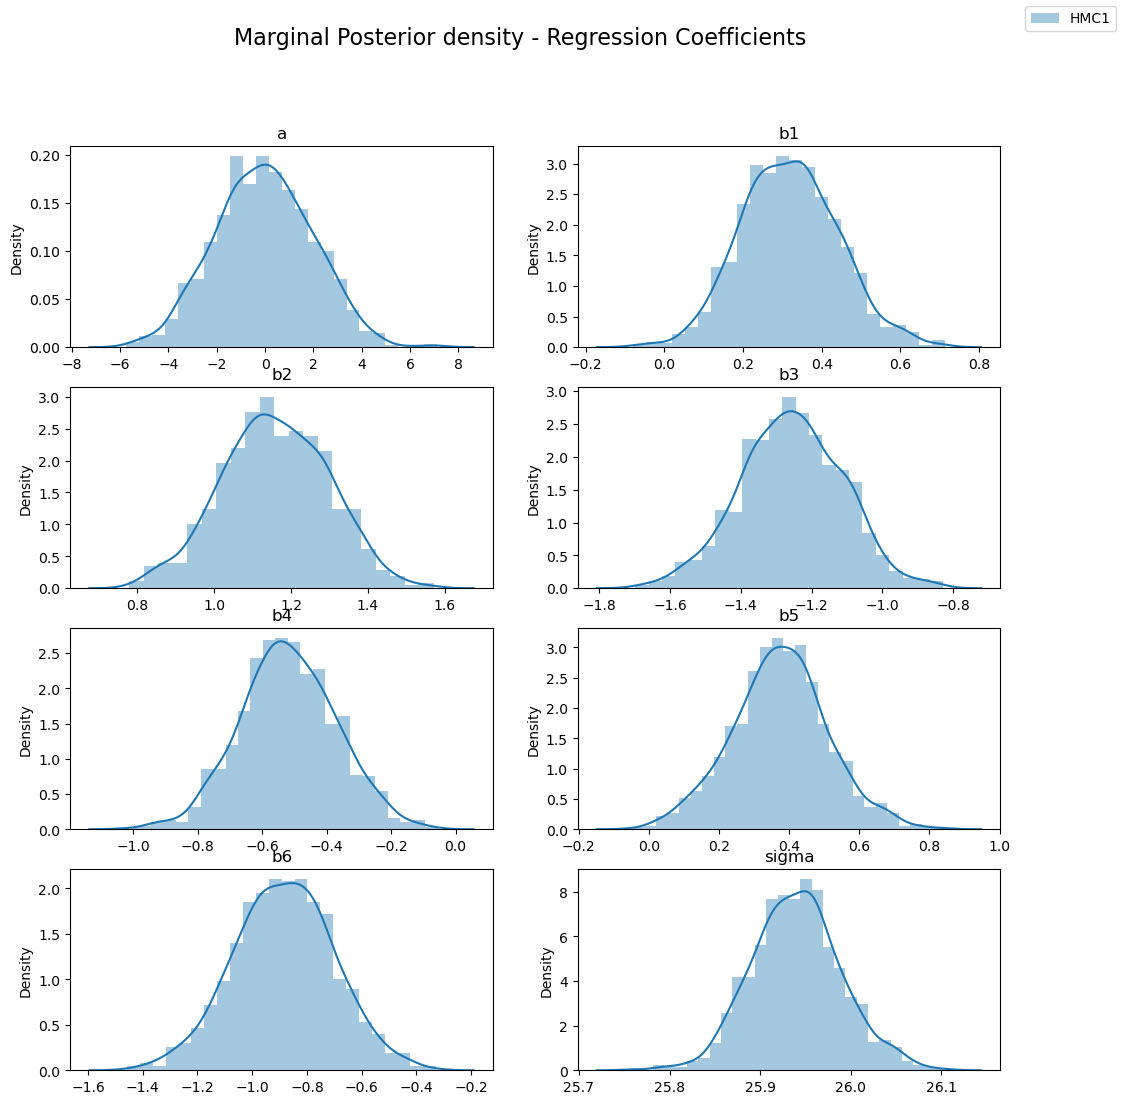

In [57]:
sites = ["a", "b1", "b2", "b3", "b4", "b5", "b6","sigma"]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="HMC1")
    #sns.distplot(hmc_samples[site], ax=ax, label="HMC2")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');